# Using a lightGBM model to predict the 2025 march madness bracket!

# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from itertools import combinations

In [3]:

DATA_PATH = "/kaggle/input/march-machine-learning-mania-2025"

def load_data():
    teams = pd.read_csv("../../data/MTeams.csv")
    seasons = pd.read_csv("../../data/MSeasons.csv") 
    seeds = pd.read_csv("../../data/MNCAATourneySeeds.csv") 
    regular_results = pd.read_csv("../../data/MRegularSeasonCompactResults.csv")
    tourney_results = pd.read_csv("../../data/MNCAATourneyCompactResults.csv") 
    detailed_results = pd.read_csv("../../data/MRegularSeasonDetailedResults.csv")  
    massey_ordinals = pd.read_csv("../../data/MMasseyOrdinals.csv")  
    
    return teams, seasons, seeds, regular_results, tourney_results, detailed_results, massey_ordinals

teams, seasons, seeds, regular_results, tourney_results, detailed_results, massey_ordinals = load_data()

print("Teams:")
display(teams.head())
print("Seasons:")
display(seasons.head())
print("Seeds:")
display(seeds.head())
print("Regular_results (regular szn results):")
display(regular_results.head())
print("Tourney results (results in March Madness):")
display(tourney_results.head())
print("Detailed results::")
display(detailed_results.head())
print("Massey_ordinals (team rankings):")
print("Note: RankingDayNum = day they were ranked. More recent days (higher number) should be accounted for more")
print("Note: OrdinalRank = team's rank on the rankingDayNum")
display(massey_ordinals.head())

Teams:


,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2025
1,1102,Air Force,1985,2025
2,1103,Akron,1985,2025
3,1104,Alabama,1985,2025
4,1105,Alabama A&M,2000,2025


Seasons:


,Season,DayZero,RegionW,RegionX,RegionY,RegionZ
0,1985,10/29/1984,East,West,Midwest,Southeast
1,1986,10/28/1985,East,Midwest,Southeast,West
2,1987,10/27/1986,East,Southeast,Midwest,West
3,1988,11/02/1987,East,Midwest,Southeast,West
4,1989,10/31/1988,East,West,Midwest,Southeast


Seeds:


,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


Regular_results (regular szn results):


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


Tourney results (results in March Madness):


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


Detailed results::


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


Massey_ordinals (team rankings):
Note: RankingDayNum = day they were ranked. More recent days (higher number) should be accounted for more
Note: OrdinalRank = team's rank on the rankingDayNum


,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
0,2003,35,SEL,1102,159
1,2003,35,SEL,1103,229
2,2003,35,SEL,1104,12
3,2003,35,SEL,1105,314
4,2003,35,SEL,1106,260


#### Max ranking day num is 133 (want to get as close to that as possible most likely)

In [4]:
massey_ordinals['RankingDayNum'].sort_values(ascending=False).head(5)

1247927    133
261738     133
261747     133
261746     133
261745     133
Name: RankingDayNum, dtype: int64

In [5]:
massey_ordinals['RankingDayNum'].value_counts()

RankingDayNum
133    375452
100    281922
93     281110
128    272708
107    271372
        ...  
54         25
75         25
89         25
103        25
53         25
Name: count, Length: 90, dtype: int64

In [6]:
regular_results.sample(10)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
106354,2009,91,1354,67,1197,52,A,0
132126,2014,77,1299,66,1175,55,H,0
79102,2004,27,1125,46,1102,38,H,0
496,1985,40,1427,76,1395,74,H,0
68925,2001,117,1164,81,1271,52,H,0
20232,1990,47,1277,94,1178,65,H,0
180490,2023,105,1124,79,1452,67,H,0
99729,2008,58,1448,70,1342,58,H,0
145126,2016,128,1161,80,1363,61,H,0
133667,2014,110,1328,86,1243,73,H,0


# Basic info about each dataset

In [7]:
print("Teams:")
display(teams.info())
print("Seasons:")
display(seasons.info())
print("Seeds:")
display(seeds.info())
print("Regular_results (regular szn results):")
display(regular_results.info())
print("Tourney results (results in March Madness):")
display(tourney_results.info())
print("Detailed results::")
display(detailed_results.info())
print("Massey_ordinals (team rankings):")
print("Note: RankingDayNum = day they were ranked. More recent days (higher number) should be accounted for more")
print("Note: OrdinalRank = team's rank on the rankingDayNum")
display(massey_ordinals.info())


Teams:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TeamID         380 non-null    int64 
 1   TeamName       380 non-null    object
 2   FirstD1Season  380 non-null    int64 
 3   LastD1Season   380 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 12.0+ KB


None

Seasons:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Season   41 non-null     int64 
 1   DayZero  41 non-null     object
 2   RegionW  41 non-null     object
 3   RegionX  41 non-null     object
 4   RegionY  41 non-null     object
 5   RegionZ  41 non-null     object
dtypes: int64(1), object(5)
memory usage: 2.1+ KB


None

Seeds:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2558 entries, 0 to 2557
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Season  2558 non-null   int64 
 1   Seed    2558 non-null   object
 2   TeamID  2558 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 60.1+ KB


None

Regular_results (regular szn results):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191796 entries, 0 to 191795
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Season   191796 non-null  int64 
 1   DayNum   191796 non-null  int64 
 2   WTeamID  191796 non-null  int64 
 3   WScore   191796 non-null  int64 
 4   LTeamID  191796 non-null  int64 
 5   LScore   191796 non-null  int64 
 6   WLoc     191796 non-null  object
 7   NumOT    191796 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 11.7+ MB


None

Tourney results (results in March Madness):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518 entries, 0 to 2517
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Season   2518 non-null   int64 
 1   DayNum   2518 non-null   int64 
 2   WTeamID  2518 non-null   int64 
 3   WScore   2518 non-null   int64 
 4   LTeamID  2518 non-null   int64 
 5   LScore   2518 non-null   int64 
 6   WLoc     2518 non-null   object
 7   NumOT    2518 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 157.5+ KB


None

Detailed results::
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117748 entries, 0 to 117747
Data columns (total 34 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Season   117748 non-null  int64 
 1   DayNum   117748 non-null  int64 
 2   WTeamID  117748 non-null  int64 
 3   WScore   117748 non-null  int64 
 4   LTeamID  117748 non-null  int64 
 5   LScore   117748 non-null  int64 
 6   WLoc     117748 non-null  object
 7   NumOT    117748 non-null  int64 
 8   WFGM     117748 non-null  int64 
 9   WFGA     117748 non-null  int64 
 10  WFGM3    117748 non-null  int64 
 11  WFGA3    117748 non-null  int64 
 12  WFTM     117748 non-null  int64 
 13  WFTA     117748 non-null  int64 
 14  WOR      117748 non-null  int64 
 15  WDR      117748 non-null  int64 
 16  WAst     117748 non-null  int64 
 17  WTO      117748 non-null  int64 
 18  WStl     117748 non-null  int64 
 19  WBlk     117748 non-null  int64 
 20  WPF      117748 non-null  int

None

Massey_ordinals (team rankings):
Note: RankingDayNum = day they were ranked. More recent days (higher number) should be accounted for more
Note: OrdinalRank = team's rank on the rankingDayNum
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5489117 entries, 0 to 5489116
Data columns (total 5 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   Season         int64 
 1   RankingDayNum  int64 
 2   SystemName     object
 3   TeamID         int64 
 4   OrdinalRank    int64 
dtypes: int64(4), object(1)
memory usage: 209.4+ MB


None

# Summary statistics

In [8]:
print("Teams:")
display(teams.describe())
print("Seasons:")
display(seasons.describe())
print("Seeds:")
display(seeds.describe())
print("Regular_results (regular szn results):")
display(regular_results.describe())
print("Tourney results (results in March Madness):")
display(tourney_results.describe())
print("Detailed results::")
display(detailed_results.describe())
print("Massey_ordinals (team rankings):")
print("Note: RankingDayNum = day they were ranked. More recent days (higher number) should be accounted for more")
print("Note: OrdinalRank = team's rank on the rankingDayNum")
display(massey_ordinals.describe())


Teams:


,TeamID,FirstD1Season,LastD1Season
count,380.000000,380.000000,380.000000
mean,1290.500000,1989.618421,2023.952632
std,109.840794,9.755814,5.686894
min,1101.000000,1985.000000,1985.000000
25%,1195.750000,1985.000000,2025.000000
50%,1290.500000,1985.000000,2025.000000
75%,1385.250000,1986.250000,2025.000000
max,1480.000000,2025.000000,2025.000000


Seasons:


,Season
count,41.000000
mean,2005.000000
std,11.979149
min,1985.000000
25%,1995.000000
50%,2005.000000
75%,2015.000000
max,2025.000000


Seeds:


,Season,TeamID
count,2558.000000,2558.000000
mean,2004.376466,1290.900704
std,11.449682,103.447343
min,1985.000000,1101.000000
25%,1994.250000,1208.000000
50%,2004.000000,1285.000000
75%,2014.000000,1387.000000
max,2024.000000,1463.000000


Regular_results (regular szn results):


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,NumOT
count,191796.000000,191796.000000,191796.000000,191796.000000,191796.000000,191796.000000,191796.000000
mean,2006.271257,73.602072,1287.599757,76.855664,1283.342286,64.771205,0.048937
std,11.623911,34.229230,104.920419,11.833224,105.102958,11.201711,0.258969
min,1985.000000,0.000000,1101.000000,34.000000,1101.000000,20.000000,0.000000
25%,1996.000000,45.000000,1199.000000,69.000000,1191.000000,57.000000,0.000000
50%,2007.000000,75.000000,1285.000000,76.000000,1281.000000,64.000000,0.000000
75%,2016.000000,103.000000,1380.000000,84.000000,1375.000000,72.000000,0.000000
max,2025.000000,132.000000,1480.000000,186.000000,1480.000000,150.000000,6.000000


Tourney results (results in March Madness):


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,NumOT
count,2518.000000,2518.000000,2518.000000,2518.000000,2518.000000,2518.000000,2518.000000
mean,2004.374106,139.150913,1284.984114,76.867355,1291.419778,65.077442,0.066720
std,11.447616,4.218254,101.039491,11.768184,103.424835,11.043525,0.278191
min,1985.000000,134.000000,1101.000000,43.000000,1101.000000,29.000000,0.000000
25%,1994.250000,136.000000,1207.000000,69.000000,1209.000000,58.000000,0.000000
50%,2004.000000,137.000000,1276.000000,76.000000,1286.500000,64.000000,0.000000
75%,2014.000000,139.000000,1385.000000,84.000000,1387.000000,72.000000,0.000000
max,2024.000000,154.000000,1463.000000,149.000000,1463.000000,115.000000,3.000000


Detailed results::


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,NumOT,WFGM,WFGA,WFGM3,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
count,117748.000000,117748.000000,117748.00000,117748.000000,117748.000000,117748.000000,117748.000000,117748.000000,117748.000000,117748.000000,...,117748.000000,117748.000000,117748.000000,117748.000000,117748.000000,117748.000000,117748.000000,117748.000000,117748.000000,117748.000000
mean,2014.146355,70.294986,1288.25451,75.878936,1283.138830,63.888287,0.068689,26.401824,55.760242,7.347445,...,20.159790,12.073403,17.732454,10.461740,21.625650,11.409722,13.888907,6.004739,2.868185,19.305780
std,6.515929,35.772556,105.34750,10.998547,104.795432,10.848767,0.305098,4.680314,7.456374,3.119260,...,6.068136,5.344049,7.081056,4.221039,4.518197,3.724567,4.382700,2.745969,2.019050,4.553353
min,2003.000000,0.000000,1101.00000,34.000000,1101.000000,20.000000,0.000000,10.000000,26.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,4.000000
25%,2009.000000,40.000000,1199.00000,68.000000,1192.000000,57.000000,0.000000,23.000000,51.000000,5.000000,...,16.000000,8.000000,13.000000,7.000000,19.000000,9.000000,11.000000,4.000000,1.000000,16.000000
50%,2014.000000,73.000000,1287.00000,75.000000,1282.000000,64.000000,0.000000,26.000000,55.000000,7.000000,...,20.000000,12.000000,17.000000,10.000000,21.000000,11.000000,14.000000,6.000000,3.000000,19.000000
75%,2020.000000,101.000000,1381.00000,83.000000,1374.000000,71.000000,0.000000,29.000000,60.000000,9.000000,...,24.000000,15.000000,22.000000,13.000000,25.000000,14.000000,17.000000,8.000000,4.000000,22.000000
max,2025.000000,132.000000,1480.00000,149.000000,1480.000000,144.000000,6.000000,57.000000,103.000000,26.000000,...,59.000000,48.000000,65.000000,36.000000,49.000000,31.000000,41.000000,22.000000,18.000000,45.000000


Massey_ordinals (team rankings):
Note: RankingDayNum = day they were ranked. More recent days (higher number) should be accounted for more
Note: OrdinalRank = team's rank on the rankingDayNum


,Season,RankingDayNum,TeamID,OrdinalRank
count,5.489117e+06,5.489117e+06,5.489117e+06,5.489117e+06
mean,2.015525e+03,8.474585e+01,1.285712e+03,1.737884e+02
std,6.081657e+00,3.303180e+01,1.051970e+02,1.015146e+02
min,2.003000e+03,0.000000e+00,1.101000e+03,1.000000e+00
25%,2.011000e+03,5.800000e+01,1.195000e+03,8.600000e+01
50%,2.016000e+03,8.600000e+01,1.284000e+03,1.730000e+02
75%,2.020000e+03,1.140000e+02,1.377000e+03,2.610000e+02
max,2.025000e+03,1.330000e+02,1.480000e+03,3.640000e+02


# Checking for null values  ---> Update: no nulls

In [9]:
display(teams.isnull().sum())
display(seasons.isnull().sum())
display(seeds.isnull().sum())
display(regular_results.isnull().sum())
display(tourney_results.isnull().sum())
display(detailed_results.isnull().sum())
display(massey_ordinals.isnull().sum())

TeamID           0
TeamName         0
FirstD1Season    0
LastD1Season     0
dtype: int64

Season     0
DayZero    0
RegionW    0
RegionX    0
RegionY    0
RegionZ    0
dtype: int64

Season    0
Seed      0
TeamID    0
dtype: int64

Season     0
DayNum     0
WTeamID    0
WScore     0
LTeamID    0
LScore     0
WLoc       0
NumOT      0
dtype: int64

Season     0
DayNum     0
WTeamID    0
WScore     0
LTeamID    0
LScore     0
WLoc       0
NumOT      0
dtype: int64

Season     0
DayNum     0
WTeamID    0
WScore     0
LTeamID    0
LScore     0
WLoc       0
NumOT      0
WFGM       0
WFGA       0
WFGM3      0
WFGA3      0
WFTM       0
WFTA       0
WOR        0
WDR        0
WAst       0
WTO        0
WStl       0
WBlk       0
WPF        0
LFGM       0
LFGA       0
LFGM3      0
LFGA3      0
LFTM       0
LFTA       0
LOR        0
LDR        0
LAst       0
LTO        0
LStl       0
LBlk       0
LPF        0
dtype: int64

Season           0
RankingDayNum    0
SystemName       0
TeamID           0
OrdinalRank      0
dtype: int64

# Checking for duplicates --> Update: no duplicates

In [10]:
display(teams.duplicated().sum())
display(seasons.duplicated().sum())
display(seeds.duplicated().sum())
display(regular_results.duplicated().sum())
display(tourney_results.duplicated().sum())
display(detailed_results.duplicated().sum())
display(massey_ordinals.duplicated().sum())


np.int64(0)

np.int64(0)

np.int64(0)

np.int64(0)

np.int64(0)

np.int64(0)

np.int64(0)

In [11]:
def compute_team_stats(regular_results):
    all_games = pd.concat([
        regular_results[['Season', 'WTeamID', 'WScore', 'LScore']],
        regular_results[['Season', 'LTeamID', 'LScore', 'WScore']].rename(
            columns={'LTeamID': 'WTeamID', 'LScore': 'WScore', 'WScore': 'LScore'}
        )
    ])

    all_games['PointDiff'] = all_games['WScore'] - all_games['LScore']

    team_stats = all_games.groupby(['Season', 'WTeamID']).agg(
        games_played=('WScore', 'count'),
        avg_points=('WScore', 'mean'),
        avg_points_allowed=('LScore', 'mean'),
        avg_point_diff=('PointDiff', 'mean'),
        win_count=('WScore', 'count')  
    ).reset_index().rename(columns={'WTeamID': 'TeamID'})

    return team_stats

team_stats = compute_team_stats(regular_results)


# Using regex to turn seeds from "Y06" to 6, "Z12" to 12, etc.

In [12]:
seeds.sample(10)

,Season,Seed,TeamID
1581,2009,Y06,1452
1338,2005,Z07,1150
1614,2010,W06,1266
732,1996,X13,1145
1967,2015,X05,1428
1559,2009,W16,1190
221,1988,X14,1293
741,1996,Y06,1231
2142,2017,Z10,1455
542,1993,X15,1123


In [13]:
seeds['SeedInt'] = seeds['Seed'].str.extract('(\d+)').astype(int)
seeds.sample(10)

,Season,Seed,TeamID,SeedInt
1519,2008,Y08,1280,8
590,1994,W15,1351,15
1081,2001,Z09,1201,9
564,1993,Z05,1307,5
2184,2018,X16,1335,16
1491,2008,W13,1457,13
2454,2023,X16a,1369,16
1600,2009,Z08,1140,8
1754,2012,W13,1285,13
450,1992,W03,1269,3


# Feature Engineering

### Feature 1. win percentage

In [14]:
wins = regular_results.groupby('WTeamID').size()  
losses = regular_results.groupby('LTeamID').size() 

team_stats = pd.DataFrame({
    'Wins': wins,
    'Losses': losses
}).fillna(0)  

team_stats['Total_Games'] = team_stats['Wins'] + team_stats['Losses']
team_stats['Win_Percentage'] = team_stats['Wins'] / team_stats['Total_Games']

team_stats = team_stats[['Win_Percentage']]

team_stats = team_stats.reset_index()

# Because detailed_results contains individual games, we have to group by team ID (which might be in both the WTeamID col & LTeamID col)

In [17]:
win_stats = detailed_results.groupby('WTeamID').agg(
    {
        'WScore': 'mean',
        'WAst': 'mean',
        'WFGM': 'mean',
        'WFGA': 'mean',
        'WFGM3': 'mean',
        'WFGA3': 'mean',
        'WFTM': 'mean',
        'WFTA': 'mean',
        'WOR': 'mean',
        'WDR': 'mean',
        'WStl': 'mean',
        'WBlk': 'mean',
        'WPF': 'mean',
    }).reset_index()

loss_stats = detailed_results.groupby('LTeamID').agg(
    {
        'LScore': 'mean',
        'LAst': 'mean',
        'LFGM': 'mean',
        'LFGA': 'mean',
        'LFGM3': 'mean',
        'LFGA3': 'mean',
        'LFTM': 'mean',
        'LFTA': 'mean',
        'LOR': 'mean',
        'LDR': 'mean',
        'LStl': 'mean',
        'LBlk': 'mean',
        'LPF': 'mean',
    }).reset_index()

win_stats.columns = ['TeamID', 'Win_Score', 'Win_Ast', 'Win_FGM', 'Win_FGA', 'Win_FGM3', 'Win_FGA3', 'Win_FTM', 'Win_FTA', 
                     'Win_OR', 'Win_DR', 'Win_Stl', 'Win_Blk', 'Win_PF']

loss_stats.columns = ['TeamID', 'Loss_Score', 'Loss_Ast', 'Loss_FGM', 'Loss_FGA', 'Loss_FGM3', 'Loss_FGA3', 'Loss_FTM', 'Loss_FTA',
                      'Loss_OR', 'Loss_DR', 'Loss_Stl', 'Loss_Blk', 'Loss_PF']

team_stats = pd.merge(win_stats, loss_stats, on='TeamID', how='outer')

# Feature engineering ---> sum each team's stats in both the win and loss columns to get their total season stats

In [19]:


team_stats['Total_Score'] = (team_stats['Win_Score'] + team_stats['Loss_Score']) / 2
team_stats['Total_Ast'] = (team_stats['Win_Ast'] + team_stats['Loss_Ast']) / 2
team_stats['Total_FGM'] = (team_stats['Win_FGM'] + team_stats['Loss_FGM']) / 2
team_stats['Total_FGA'] = (team_stats['Win_FGA'] + team_stats['Loss_FGA']) / 2
team_stats['Total_FGM3'] = (team_stats['Win_FGM3'] + team_stats['Loss_FGM3']) / 2
team_stats['Total_FGA3'] = (team_stats['Win_FGA3'] + team_stats['Loss_FGA3']) / 2
team_stats['Total_FTM'] = (team_stats['Win_FTM'] + team_stats['Loss_FTM']) / 2
team_stats['Total_FTA'] = (team_stats['Win_FTA'] + team_stats['Loss_FTA']) / 2
team_stats['Total_OR'] = (team_stats['Win_OR'] + team_stats['Loss_OR']) / 2
team_stats['Total_DR'] = (team_stats['Win_DR'] + team_stats['Loss_DR']) / 2
team_stats['Total_Stl'] = (team_stats['Win_Stl'] + team_stats['Loss_Stl']) / 2
team_stats['Total_Blk'] = (team_stats['Win_Blk'] + team_stats['Loss_Blk']) / 2
team_stats['Total_PF'] = (team_stats['Win_PF'] + team_stats['Loss_PF']) / 2

team_stats.head()


,TeamID,Win_Score,Win_Ast,Win_FGM,Win_FGA,Win_FGM3,Win_FGA3,Win_FTM,Win_FTA,Win_OR,...,Total_FGA,Total_FGM3,Total_FGA3,Total_FTM,Total_FTA,Total_OR,Total_DR,Total_Stl,Total_Blk,Total_PF
0,1101,76.608108,15.162162,26.398649,55.871622,7.222973,18.925676,16.587838,22.648649,8.675676,...,55.717248,6.611486,18.846071,14.662182,20.375223,8.511491,21.502225,8.000991,2.350502,21.009184
1,1102,70.122807,15.782456,23.877193,48.561404,8.557895,21.214035,13.810526,19.157895,7.070175,...,49.206823,7.727496,21.355039,12.146688,17.385016,6.855668,21.223011,6.242855,2.326357,17.195839
2,1103,75.768898,14.853132,26.049676,55.710583,8.604752,22.749460,15.064795,21.589633,10.362851,...,56.727192,7.918078,23.000763,13.559257,19.484899,10.613244,23.081525,6.267301,3.246118,18.827767
3,1104,77.849658,14.170843,26.917995,57.485194,7.785877,21.580866,16.227790,23.015945,11.665148,...,57.148734,7.039148,21.106317,14.695123,21.020608,11.449903,24.700854,6.545862,4.384217,18.320222
4,1105,73.000000,13.434343,24.595960,56.358586,6.060606,17.797980,17.747475,25.919192,11.878788,...,56.506352,5.626774,18.029578,15.200796,22.744302,11.408806,23.976916,7.142745,3.763399,19.305217


In [20]:
game_data = pd.merge(tourney_results, team_stats, how="left", left_on="WTeamID", right_on="TeamID", suffixes=("_W", "_L"))
game_data = pd.merge(game_data, team_stats, how="left", left_on="LTeamID", right_on="TeamID", suffixes=("_W", "_L"))


In [ ]:
game_data.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,TeamID_W,Win_Score_W,...,Total_FGM3_L,Total_FGA3_L,Total_FTM_L,Total_FTA_L,Total_OR_L,Total_DR_L,Total_Stl_L,Total_Blk_L,Total_PF_L,Total_Possessions_L
0,1985,136,1116,63,1234,54,N,0,1116,80.630485,...,6.930898,19.951073,14.652423,20.470088,10.847192,24.371355,6.338546,3.859366,16.848252,69.721326
1,1985,136,1120,59,1345,58,N,0,1120,79.485000,...,6.609291,19.198348,13.724449,19.486900,11.088802,23.702157,5.777104,3.655334,18.033274,68.976798
2,1985,136,1207,68,1250,43,N,0,1207,75.352041,...,6.688760,18.488987,14.024335,19.232593,8.987662,24.795226,6.206728,2.772299,17.918088,68.408154
3,1985,136,1229,58,1425,55,N,0,1229,72.620000,...,6.204006,18.016977,13.238591,19.606784,10.532248,24.032329,6.438712,4.091930,17.639164,70.767562
4,1985,136,1242,49,1325,38,N,0,1242,79.946037,...,7.466654,21.520989,14.234508,20.062682,9.964667,23.606213,6.967581,2.765533,18.139011,69.601774


# Feature engineering: creating new cols for predictions (AST difference, TRB difference, etc)

In [22]:
game_data['Score_diff'] = game_data['WScore'] - game_data['LScore']
game_data['Ast_diff'] = game_data['Win_Ast_W'] - game_data['Loss_Ast_L']
game_data['FGM_diff'] = game_data['Win_FGM_W'] - game_data['Loss_FGM_L']
game_data['DR_diff'] = game_data['Win_DR_W'] - game_data['Win_DR_W'] 
game_data['DR_diff'] = game_data['Win_DR_W'] - game_data['Loss_DR_L']
game_data['TRB_diff'] = game_data['Win_OR_W'] + game_data['Win_DR_W'] - (game_data['Loss_OR_L'] + game_data['Loss_DR_L'])
game_data['Stl_diff'] = game_data['Win_Stl_W'] - game_data['Loss_Stl_L']
game_data['Blk_diff'] = game_data['Win_Blk_W'] - game_data['Loss_Blk_L']
game_data['PF_diff'] = game_data['Win_PF_W'] - game_data['Loss_PF_L']
game_data['FGM3_diff'] = game_data['Win_FGM3_W'] - game_data['Loss_FGM3_L']
game_data['FTM_diff'] = game_data['Win_FTM_W'] - game_data['Loss_FTM_L']
game_data['FTA_diff'] = game_data['Win_FTA_W'] - game_data['Loss_FTA_L']
game_data['FGA_diff'] = game_data['Win_FGA_W'] - game_data['Loss_FGA_L']


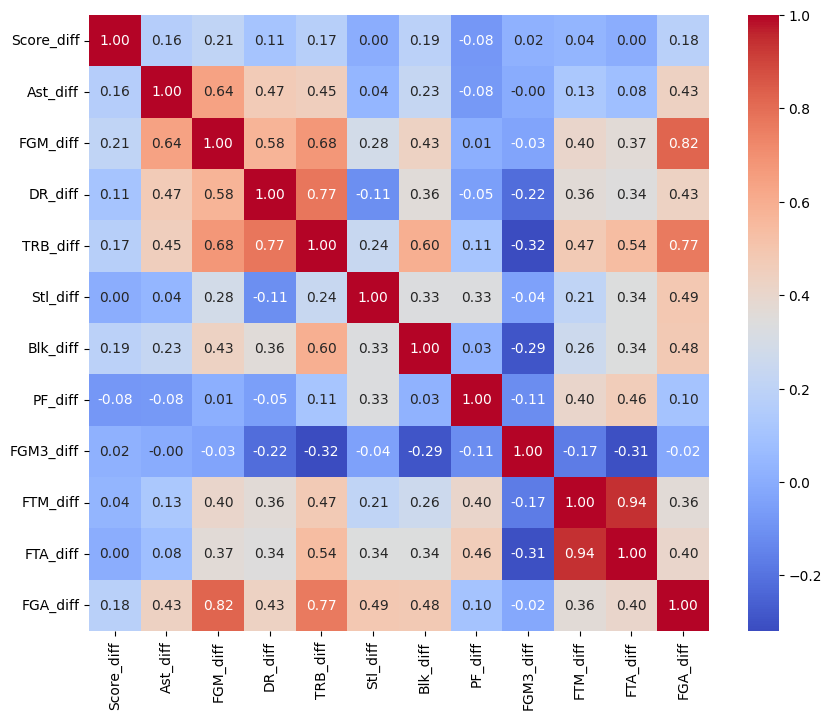

In [24]:
corr = game_data[['Score_diff', 'Ast_diff', 'FGM_diff', 'DR_diff', 'TRB_diff', 'Stl_diff', 'Blk_diff', 'PF_diff', 'FGM3_diff', 'FTM_diff', 'FTA_diff', 'FGA_diff']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()


# Linear regression model using new features. Target variable = score difference

In [ ]:
X = game_data[['Ast_diff', 'FGM_diff', 'DR_diff', 'TRB_diff', 'Stl_diff', 'Blk_diff', 'PF_diff', 'Possessions_diff', 'FGM3_diff', 'FTM_diff', 'FTA_diff', 'FGA_diff']]
y = game_data['Score_diff']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

# RMSE = 8.13

In [ ]:
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 8.133685191761584


# Make sure we're not overfitting: cross-validation RMSE = 8.43

In [ ]:
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
print(f'Cross-validated RMSE: {np.sqrt(-cv_scores.mean())}')


Cross-validated RMSE: 8.425922576374427


# Random forest

In [ ]:
import pandas as pd
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


def build_model(game_data):
    X = game_data[['Ast_diff', 'FGM_diff', 'DR_diff', 'TRB_diff', 'Stl_diff', 
                   'Blk_diff', 'PF_diff', 'Possessions_diff', 'FGM3_diff', 
                   'FTM_diff', 'FTA_diff']]
    y = game_data['Score_diff']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    return model

def generate_submission(model, teams, team_stats, seeds, game_data, output_path="../../submissions/randomForest.csv"):
    tourney_teams = seeds[seeds['Season'] == 2024]['TeamID'].unique()
    print(f"Tourney teams for 2024: {tourney_teams}") 
    
    if len(tourney_teams) == 0:
        raise ValueError("No teams found for the 2024 season. Please check the seeds data.")
    
    # Generate possible matchups for the tournament (all combinations of two teams)
    matchups = list(combinations(tourney_teams, 2))
    print(f"Matchups: {matchups}")  

    submission_data = []
    for team1, team2 in matchups:
        if team_stats[team_stats['TeamID'] == team1].empty or team_stats[team_stats['TeamID'] == team2].empty:
            print(f"Missing stats for team {team1 if team_stats[team_stats['TeamID'] == team1].empty else team2}. Skipping matchup.")
            continue

        team1_stats = team_stats[team_stats['TeamID'] == team1].iloc[0]
        team2_stats = team_stats[team_stats['TeamID'] == team2].iloc[0]

        team1_trb = team1_stats['Total_OR'] + team1_stats['Total_DR']
        team2_trb = team2_stats['Total_OR'] + team2_stats['Total_DR']
        
        features = [
            team1_stats['Total_Ast'] - team2_stats['Total_Ast'],
            team1_stats['Total_FGM'] - team2_stats['Total_FGM'],
            team1_stats['Total_DR'] - team2_stats['Total_DR'],
            team1_trb - team2_trb,
            team1_stats['Total_Stl'] - team2_stats['Total_Stl'],
            team1_stats['Total_Blk'] - team2_stats['Total_Blk'],
            team1_stats['Total_PF'] - team2_stats['Total_PF'],
            team1_stats['Total_Possessions'] - team2_stats['Total_Possessions'],
            team1_stats['Total_FGM3'] - team2_stats['Total_FGM3'],
            team1_stats['Total_FTM'] - team2_stats['Total_FTM'],
            team1_stats['Total_FTA'] - team2_stats['Total_FTA']
        ]
        print(f"Features for matchup {team1} vs {team2}: {features}")  

        matchup_id = f"2024_{min(team1, team2)}_{max(team1, team2)}"
        submission_data.append([matchup_id, features])
    
    # Converting submission data into a DataFrame
    submission_df = pd.DataFrame(submission_data, columns=['ID', 'Features'])
    

    X_submission = pd.DataFrame(submission_df['Features'].tolist(), 
                                columns=['Ast_diff', 'FGM_diff', 'DR_diff', 'TRB_diff', 'Stl_diff', 
                                         'Blk_diff', 'PF_diff', 'Possessions_diff', 'FGM3_diff', 
                                         'FTM_diff', 'FTA_diff'])
    
    if X_submission.empty:
        raise ValueError("X_submission is empty. Please check the features data.")
    
    print(f"X_submission:\n{X_submission}")  # Debugging line

    submission_df['Pred'] = model.predict(X_submission)
    
    # saving results to a CSV file
    submission_df[['ID', 'Pred']].to_csv(output_path, index=False)
    print(f"Submission file saved at: {output_path}")

def main():
    model = build_model(game_data)
    generate_submission(model, teams, team_stats, seeds, game_data)

main()


Tourney teams for 2024: [1163 1235 1228 1120 1361 1140 1450 1194 1321 1179 1182 1412 1463 1287
 1355 1391 1314 1112 1124 1104 1388 1155 1173 1280 1277 1305 1307 1213
 1158 1159 1253 1224 1447 1345 1397 1166 1242 1211 1376 1400 1429 1395
 1161 1438 1332 1270 1359 1103 1389 1212 1286 1222 1266 1246 1181 1458
 1403 1196 1304 1401 1129 1160 1301 1241 1436 1324 1443 1255]
Matchups: [(np.int64(1163), np.int64(1235)), (np.int64(1163), np.int64(1228)), (np.int64(1163), np.int64(1120)), (np.int64(1163), np.int64(1361)), (np.int64(1163), np.int64(1140)), (np.int64(1163), np.int64(1450)), (np.int64(1163), np.int64(1194)), (np.int64(1163), np.int64(1321)), (np.int64(1163), np.int64(1179)), (np.int64(1163), np.int64(1182)), (np.int64(1163), np.int64(1412)), (np.int64(1163), np.int64(1463)), (np.int64(1163), np.int64(1287)), (np.int64(1163), np.int64(1355)), (np.int64(1163), np.int64(1391)), (np.int64(1163), np.int64(1314)), (np.int64(1163), np.int64(1112)), (np.int64(1163), np.int64(1124)), (np.int

In [26]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# ------------------------------------------
# Helper function: compute features and target from tournament results
def compute_features_from_tourney(tourney_data, team_stats):
    """
    For each game in tourney_data, compute feature differences using team_stats.
    Returns:
      X: DataFrame with features
      y: Numpy array with target (Score_diff = WScore - LScore)
    """
    features_list = []
    score_diff_list = []
    for idx, row in tourney_data.iterrows():
        team1 = row['WTeamID']  # In the actual game, team1 (winner) is known.
        team2 = row['LTeamID']  # And team2 (loser) is known.
        
        # Get stats for both teams from team_stats
        if team_stats[team_stats['TeamID'] == team1].empty or team_stats[team_stats['TeamID'] == team2].empty:
            continue  # Skip if stats for either team are missing
        t1 = team_stats[team_stats['TeamID'] == team1].iloc[0]
        t2 = team_stats[team_stats['TeamID'] == team2].iloc[0]
        
        # Compute total rebounds for each team
        t1_trb = t1['Total_OR'] + t1['Total_DR']
        t2_trb = t2['Total_OR'] + t2['Total_DR']
        
        # Calculate feature differences (using your aggregated "Total_" stats)
        feats = [
            t1['Total_Ast'] - t2['Total_Ast'],            # Assist difference
            t1['Total_FGM'] - t2['Total_FGM'],            # Field Goals Made difference
            t1['Total_DR'] - t2['Total_DR'],              # Defensive Rebounds difference
            t1_trb - t2_trb,                             # Total Rebounds difference
            t1['Total_Stl'] - t2['Total_Stl'],            # Steals difference
            t1['Total_Blk'] - t2['Total_Blk'],            # Blocks difference
            t1['Total_PF'] - t2['Total_PF'],              # Personal Fouls difference
            t1['Total_FGM3'] - t2['Total_FGM3'],          # Three-Point FG Made difference
            t1['Total_FTM'] - t2['Total_FTM'],            # Free Throws Made difference
            t1['Total_FTA'] - t2['Total_FTA']             # Free Throws Attempted difference
        ]
        features_list.append(feats)
        # Target: actual score difference
        score_diff_list.append(row['WScore'] - row['LScore'])
    
    X = pd.DataFrame(features_list, columns=['Ast_diff', 'FGM_diff', 'DR_diff', 'TRB_diff', 'Stl_diff', 
                                               'Blk_diff', 'PF_diff', 'FGM3_diff', 
                                               'FTM_diff', 'FTA_diff'])
    y = np.array(score_diff_list)
    return X, y

# ------------------------------------------
# Model building: train a model on tournament data from 2018-2024
def build_model(tourney_data, team_stats):
    # Filter tournament data from 2018 through 2024
    train_data = tourney_data[tourney_data['Season'] >= 2018].copy()
    
    # Compute features and target for training
    X, y = compute_features_from_tourney(train_data, team_stats)
    
    # Optionally, you can split into train and test sets here for internal evaluation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Print training RMSE for a sanity check
    y_pred_train = model.predict(X_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    print("Training RMSE:", rmse_train)
    
    # Optionally evaluate on X_test if needed
    return model

# ------------------------------------------
# Testing model accuracy per season (2018 to 2024)
def test_model_on_seasons(model, tourney_data, team_stats):
    seasons = sorted(tourney_data[tourney_data['Season'] >= 2018]['Season'].unique())
    for season in seasons:
        season_data = tourney_data[tourney_data['Season'] == season]
        X_season, y_season = compute_features_from_tourney(season_data, team_stats)
        if len(X_season) == 0:
            print(f"Season {season} has no data for prediction.")
            continue
        y_pred = model.predict(X_season)
        rmse = np.sqrt(mean_squared_error(y_season, y_pred))
        print(f"Season {season} RMSE: {rmse}")

# ------------------------------------------
# Main function
def main():
    # Assuming these DataFrames are already loaded in memory:
    # tourney_results, team_stats
    # e.g., tourney_results = pd.read_csv('tourney_results.csv'), etc.
    
    # Build the model on tournament data from 2018 to 2024
    model = build_model(tourney_results, team_stats)
    
    # Evaluate the model by predicting outcomes for each season (2018-2024)
    test_model_on_seasons(model, tourney_results, team_stats)

# Call main
main()


Training RMSE: 3.2227316182944516
Season 2018 RMSE: 4.6670799951062065
Season 2019 RMSE: 5.718761654461196
Season 2021 RMSE: 4.374831998623745
Season 2022 RMSE: 5.548222299820505
Season 2023 RMSE: 3.6931281803458
Season 2024 RMSE: 4.480443067054242


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

sns.set(style="whitegrid")

def compute_features_from_tourney(tourney_data, team_stats):
    features_list = []
    score_diff_list = []
    
    for idx, row in tourney_data.iterrows():
        team1 = row['WTeamID']  # winning team
        team2 = row['LTeamID']  # losing team
        
        # Get aggregated stats for both teams; skip game if stats are missing
        if team_stats[team_stats['TeamID'] == team1].empty or team_stats[team_stats['TeamID'] == team2].empty:
            continue
        
        t1 = team_stats[team_stats['TeamID'] == team1].iloc[0]
        t2 = team_stats[team_stats['TeamID'] == team2].iloc[0]
        
        # Compute total rebounds as sum of offensive and defensive rebounds
        t1_trb = t1['Total_OR'] + t1['Total_DR']
        t2_trb = t2['Total_OR'] + t2['Total_DR']
        
        feats = [
            t1['Total_Ast'] - t2['Total_Ast'],           ]
            t1['Total_FGM'] - t2['Total_FGM'],          
            t1['Total_DR'] - t2['Total_DR'],              
            t1_trb - t2_trb,                             
            t1['Total_Stl'] - t2['Total_Stl'],          
            t1['Total_Blk'] - t2['Total_Blk'],          
            t1['Total_PF'] - t2['Total_PF'],            
            t1['Total_Possessions'] - t2['Total_Possessions'], 
            t1['Total_FGM3'] - t2['Total_FGM3'],        
            t1['Total_FTM'] - t2['Total_FTM'],      
            t1['Total_FTA'] - t2['Total_FTA']       
        ]
        features_list.append(feats)
        # Target: actual score difference
        score_diff_list.append(row['WScore'] - row['LScore'])
    
    X = pd.DataFrame(features_list, columns=['Ast_diff', 'FGM_diff', 'DR_diff', 'TRB_diff', 'Stl_diff', 
                                               'Blk_diff', 'PF_diff', 'Possessions_diff', 'FGM3_diff', 
                                               'FTM_diff', 'FTA_diff'])
    y = np.array(score_diff_list)
    return X, y

# Function to perform rolling-window validation with additional metrics and plotting
def rolling_window_validation(tourney_results, team_stats):
    # Consider only seasons from 2018 onward
    seasons = sorted(tourney_results[tourney_results['Season'] >= 2018]['Season'].unique())
    errors = {}
    r2_scores = {}
    mae_scores = {}
    
    for i in range(1, len(seasons)):
        train_seasons = seasons[:i]
        test_season = seasons[i]
        
        train_data = tourney_results[tourney_results['Season'].isin(train_seasons)]
        test_data = tourney_results[tourney_results['Season'] == test_season]
        X_train, y_train = compute_features_from_tourney(train_data, team_stats)
        X_test, y_test = compute_features_from_tourney(test_data, team_stats)
        
        if len(X_train) == 0 or len(X_test) == 0:
            print(f"Skipping season {test_season} due to insufficient data.")
            continue
        
        # Training a RandomForestRegressor model on the training data (2018 - 2024 seasons)
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        
        # Predict on the test set
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        
        errors[test_season] = rmse
        r2_scores[test_season] = r2
        mae_scores[test_season] = mae
        
        print(f"Train on seasons {train_seasons}, test on season {test_season} -> RMSE: {rmse:.2f}, R2: {r2:.2f}, MAE: {mae:.2f}")
    
    # Plot RMSE and MAE for each test season
    plt.figure(figsize=(10, 6))
    plt.plot(list(errors.keys()), list(errors.values()), marker='o', label='RMSE')
    plt.plot(list(mae_scores.keys()), list(mae_scores.values()), marker='o', label='MAE')
    plt.xlabel('Test Season')
    plt.ylabel('Error')
    plt.title('Rolling Window Validation Errors (2018 onwards)')
    plt.legend()
    plt.show()
    
    # Plot R^2 scores
    plt.figure(figsize=(10, 6))
    plt.plot(list(r2_scores.keys()), list(r2_scores.values()), marker='o', label='R2 Score', color='green')
    plt.xlabel('Test Season')
    plt.ylabel('R2 Score')
    plt.title('Rolling Window Validation R2 Score (2018 onwards)')
    plt.legend()
    plt.show()
    
    return errors, r2_scores, mae_scores

# Train on all past seasons since 2018 and predict each season's outcomes
def main():
    errors, r2_scores, mae_scores = rolling_window_validation(tourney_results, team_stats)
    
    print("Rolling window validation metrics:")
    print("RMSE by season:", errors)
    print("R2 by season:", r2_scores)
    print("MAE by season:", mae_scores)

main()


KeyError: 'Total_Possessions'

Validation RMSE: 8.80, R^2: 0.00, MAE: 7.01
Test RMSE: 8.96, R^2: 0.05, MAE: 6.91


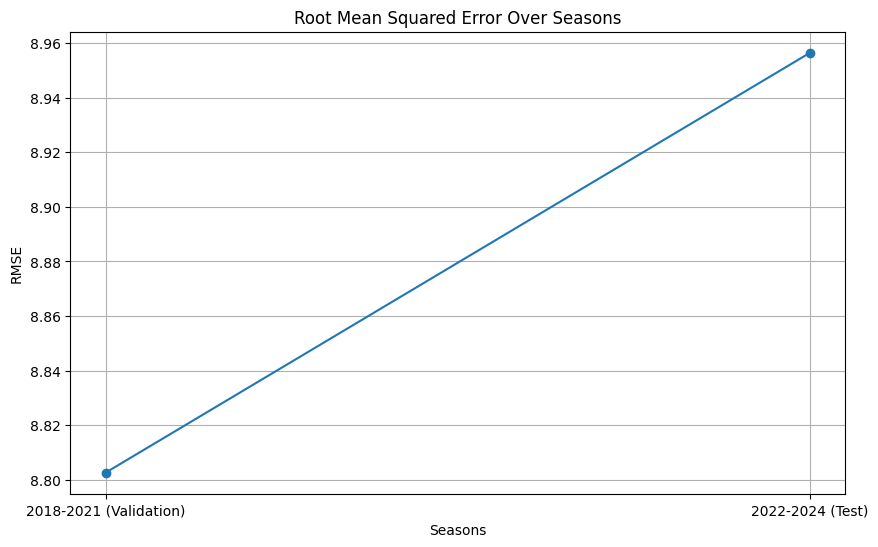

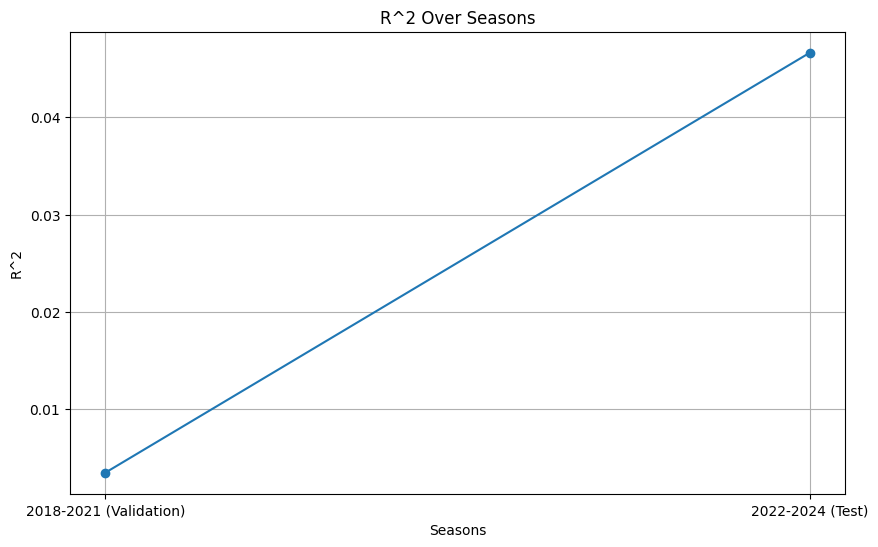

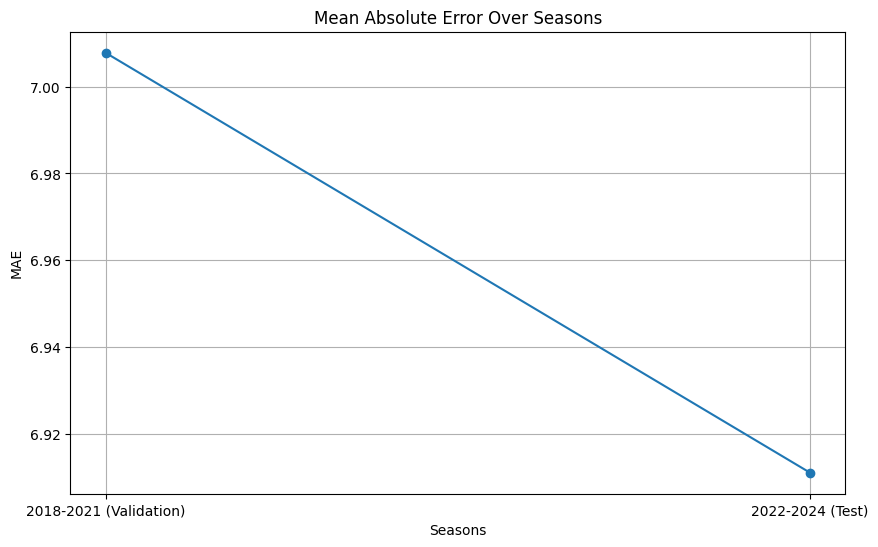

In [33]:
def compute_features_from_tourney(tourney_data, team_stats):

    features_list = []
    score_diff_list = []
    
    for idx, row in tourney_data.iterrows():
        team1 = row['WTeamID']  # winning team ID
        team2 = row['LTeamID']  # losing team ID
        
        if team_stats[team_stats['TeamID'] == team1].empty or team_stats[team_stats['TeamID'] == team2].empty:
            continue
        
        t1 = team_stats[team_stats['TeamID'] == team1].iloc[0]
        t2 = team_stats[team_stats['TeamID'] == team2].iloc[0]
        
        t1_trb = t1['Total_OR'] + t1['Total_DR']
        t2_trb = t2['Total_OR'] + t2['Total_DR']
        
        feats = [
            t1['Total_Ast'] - t2['Total_Ast'],                      # Assist difference
            t1['Total_FGM'] - t2['Total_FGM'],                      # Field Goals Made difference
            t1['Total_DR'] - t2['Total_DR'],                        # Defensive Rebounds difference
            t1_trb - t2_trb,                                       # Total Rebounds difference
            t1['Total_Stl'] - t2['Total_Stl'],                      # Steals difference
            t1['Total_Blk'] - t2['Total_Blk'],                      # Blocks difference
            t1['Total_PF'] - t2['Total_PF'],                        # Personal Fouls difference
            t1['Total_FGM3'] - t2['Total_FGM3'],                    # 3-Point FG Made difference
            t1['Total_FTM'] - t2['Total_FTM'],                      # Free Throws Made difference
            t1['Total_FTA'] - t2['Total_FTA']                       # Free Throws Attempted difference
        ]
        features_list.append(feats)
        # Target: actual score difference for the game
        score_diff_list.append(row['WScore'] - row['LScore'])
    
    X = pd.DataFrame(features_list, columns=[
        'Ast_diff', 'FGM_diff', 'DR_diff', 'TRB_diff', 'Stl_diff', 
        'Blk_diff', 'PF_diff',  'FGM3_diff', 
        'FTM_diff', 'FTA_diff'
    ])
    y = np.array(score_diff_list)
    return X, y

# Function to split tourney_results by season (2010-2017 for training, 2018-2021 for validation, 2022-2024 for testing)
def split_seasons(tourney_data):
    train_data = tourney_data[tourney_data['Season'].between(2010, 2017)]
    val_data = tourney_data[tourney_data['Season'].between(2018, 2021)]
    test_data = tourney_data[tourney_data['Season'].between(2022, 2024)]
    return train_data, val_data, test_data

def train_and_evaluate(tourney_data, team_stats):
    # Split the data into train, validation, and test sets
    train_data, val_data, test_data = split_seasons(tourney_data)
    
    X_train, y_train = compute_features_from_tourney(train_data, team_stats)
    X_val, y_val = compute_features_from_tourney(val_data, team_stats)
    X_test, y_test = compute_features_from_tourney(test_data, team_stats)
    
    # Train the model on the training data (2010-2017)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    season_metrics = {
        'RMSE': [],
        'R^2': [],
        'MAE': []
    }
    
    # Predict and evaluate on validation set (2018-2021)
    y_val_pred = model.predict(X_val)
    rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
    r2_val = np.corrcoef(y_val, y_val_pred)[0, 1] ** 2  
    mae_val = np.mean(np.abs(y_val - y_val_pred))

    season_metrics['RMSE'].append(rmse_val)
    season_metrics['R^2'].append(r2_val)
    season_metrics['MAE'].append(mae_val)
    
    # Predict and evaluate on test set (2022-2024)
    y_test_pred = model.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    r2_test = np.corrcoef(y_test, y_test_pred)[0, 1] ** 2
    mae_test = np.mean(np.abs(y_test - y_test_pred))

    season_metrics['RMSE'].append(rmse_test)
    season_metrics['R^2'].append(r2_test)
    season_metrics['MAE'].append(mae_test)

    
    print("Validation RMSE: {:.2f}, R^2: {:.2f}, MAE: {:.2f}".format(rmse_val, r2_val, mae_val))
    print("Test RMSE: {:.2f}, R^2: {:.2f}, MAE: {:.2f}".format(rmse_test, r2_test, mae_test))
    
    return model, season_metrics

# plot metrics over seasons
def plot_metrics(metrics_list, metric_name, title):
    seasons = ['2018-2021 (Validation)', '2022-2024 (Test)']
    plt.figure(figsize=(10, 6))
    plt.plot(seasons, metrics_list, marker='o')
    plt.xlabel("Seasons")
    plt.ylabel(metric_name)
    plt.title(title)
    plt.grid(True)
    plt.show()

def main():
    model, season_metrics = train_and_evaluate(tourney_results, team_stats)
    
    # Plot RMSE, R^2, and MAE over the validation and test sets
    plot_metrics(season_metrics['RMSE'], 'RMSE', 'Root Mean Squared Error Over Seasons')
    plot_metrics(season_metrics['R^2'], 'R^2', 'R^2 Over Seasons')
    plot_metrics(season_metrics['MAE'], 'MAE', 'Mean Absolute Error Over Seasons')

main()



In [ ]:
codeium_test = 